In [1]:
import numpy as np
import xarray as xr
from scipy import optimize
import copy
import matplotlib.pyplot as plt
from cartopy.util import add_cyclic_point
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from scipy import stats
import areamean_dhq as areamean
from scipy.stats import linregress
import dyl_function_slope as dyl
plt.rcParams['font.family'] = 'Helvetica'

In [2]:
Rv = 461.5  # Gas constant for water vapor
Lv = 2.5e6  # Latent heat of vaporization

def calculate_beta(T, delta_T, p):
    # T_fine = interpolate_to_fine(T, p, p_fine)
    # delta_T_fine = interpolate_to_fine(delta_T, p, p_fine)
    # Calculate es, dT_dp, and dT_des as before
    dT_dp = np.gradient(T, p, axis=0)

    # Calculate beta for each time, level, and latitude
    def func(beta, delta_T, dT_dp, T, level):
        # p_adjusted = np.tile(p_fine, (181, 1)).T
        return delta_T - (beta - 1) * (p[level] * dT_dp - Rv * T ** 2 / Lv)

    # Solve for beta
    beta_init = 1.15
    beta = np.empty_like(T)
    for lat in range(T.shape[1]):
        # for level in range(p.size):
        beta[:, lat] = optimize.newton(func, beta_init, args=(delta_T[lat], dT_dp[5, lat], T[5, lat], 5))
    # Return the calculated beta array
    return beta


def calculate_transformed_u(u, beta, p):
    # Calculate u_prime as before using interpolated u and beta
    # Calculate transformed u'
    u_prime = np.empty_like(u)
    for lat in range(u.shape[1]):
        # for level in range(p.size):
        transformed_p = beta[:, lat] * p
        u_prime[::-1, lat] = np.interp(transformed_p[::-1], p[::-1], u[::-1, lat])
    # Return the calculated u_prime array
    return u_prime

def areamean_func_4D(ndarray,slice,lat_ds):
    months_label, time_label, lat_label,lon_label = ndarray.shape
    nrows = lat_label
    latsr = np.deg2rad(lat_ds['lat'].values[slice]).reshape((nrows, 1))
    weight_matrix = np.repeat(np.cos(latsr), lon_label, axis=1)
    ds_w = ndarray * weight_matrix
    weight_sum = copy.deepcopy(weight_matrix)
    #weight_sum[ds_w[0, 0, 0].isnull().data] = np.nan
    obs_mean_areamean = ds_w.sum(dim=['lat','lon']) / np.nansum(weight_sum)
    return obs_mean_areamean
def areamean_func_3D(ndarray,slice,lat_ds):
    time_label, lat_label,lon_label = ndarray.shape
    nrows = lat_label
    latsr = np.deg2rad(lat_ds['lat'].values[slice]).reshape((nrows, 1))
    #weight_matrix = np.repeat(np.cos(latsr), 1, axis=1)
    ds_w = ndarray * np.cos(latsr)
    weight_sum = copy.deepcopy(np.cos(latsr))
    #weight_sum[ds_w[0, 0, 0].isnull().data] = np.nan
    obs_mean_areamean = ds_w.sum(1) / np.nansum(weight_sum)
    return obs_mean_areamean

In [3]:
ts = xr.open_dataset(r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/h+ssp585/ts_h+ssp585_all_models_1979-2022_zonmean_289x145.nc').ts
ts_DJF = xr.open_dataset(r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/h+ssp585/ts_h+ssp585_all_models_1979-2022_zonmean_289x145.nc').ts[:,1:42]
ts_JJA = xr.open_dataset(r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/h+ssp585/ts_h+ssp585_all_models_1979-2022_zonmean_289x145.nc').ts
ts_era5 = [f'/home/dongyl/Databank/obs-data/ERA5/t2m_era5_1958-2022_288x145.nc',
           f'/home/dongyl/Databank/obs-data/ERA5/t2m_era5_1958-2022_288x145_DJF.nc',
           f'/home/dongyl/Databank/obs-data/ERA5/t2m_era5_1958-2022_288x145_JJA.nc']
ts_jra55 = [f'/home/dongyl/Databank/obs-data/JRA-55/t2m_jra55_1958-2022.nc',
            f'/home/dongyl/Databank/obs-data/JRA-55/t2m_jra55_1958-2022_DJF.nc',
            f'/home/dongyl/Databank/obs-data/JRA-55/t2m_jra55_1958-2022_JJA.nc']
ts_merra2=[f'/home/dongyl/Databank/obs-data/MERRA-2/T2M_MERRA2_1980-2024_288x145.nc',
           f'/home/dongyl/Databank/obs-data/MERRA-2/T2M_MERRA2_1980-2024_288x145_DJF.nc',
           f'/home/dongyl/Databank/obs-data/MERRA-2/T2M_MERRA2_1980-2024_288x145_JJA.nc']

gmt = areamean.mask_am4D(ts[:,1:42])##1980-2020
gmt_mme = np.nanmean(gmt,axis=0)
trends_gmt, p_values_gmt = dyl.calculate_trend(gmt)
mean_trend_gmt,_,_, mean_p_value_gmt,_ = linregress(np.arange(41),gmt_mme)

gmt_DJF = areamean.mask_am4D(ts_DJF[:,:41])##1980-2020
gmt_mme_DJF = np.nanmean(gmt_DJF,axis=0)
trends_gmt_DJF, p_values_gmt_DJF = dyl.calculate_trend(gmt_DJF)
mean_trend_gmt_DJF,_,_, mean_p_value_gmt_DJF,_ = linregress(np.arange(41),gmt_mme_DJF)

gmt_JJA = areamean.mask_am4D(ts_JJA[:,1:42])##1980-2020
gmt_mme_JJA = np.nanmean(gmt_JJA,axis=0)
trends_gmt_JJA, p_values_gmt_JJA = dyl.calculate_trend(gmt_JJA)
mean_trend_gmt_JJA,_,_, mean_p_value_gmt_JJA,_ = linregress(np.arange(41),gmt_mme_JJA)
########################计算观测中2m温度#######################
ts_obs_ANN = [f'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/ERA5/t2m_era5_1958-2022_288x145.nc',
           f'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/JRA-55/t2m_jra55_1958-2022.nc',
           f'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/MERRA-2/T2M_MERRA2_1980-2024_288x145.nc']
ts_obs_DJF = [f'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/ERA5/t2m_era5_1958-2022_288x145_DJF.nc',
            f'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/JRA-55/t2m_jra55_1958-2022_DJF.nc',
            f'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/MERRA-2/T2M_MERRA2_1980-2024_288x145_DJF.nc']
ts_obs_JJA=[f'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/ERA5/t2m_era5_1958-2022_288x145_JJA.nc',
           f'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/JRA-55/t2m_jra55_1958-2022_JJA.nc',
           f'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/MERRA-2/T2M_MERRA2_1980-2024_288x145_JJA.nc']
ts_obs_ANN_value=np.zeros((3,41))
ts_obs_DJF_value=np.zeros((3,41))
ts_obs_JJA_value=np.zeros((3,41))
for i in range(len(ts_obs_ANN)):
    if i==0:
        ts_ANN = xr.open_dataset(ts_obs_ANN[i]).t2m[22:63]
        ts_DJF = xr.open_dataset(ts_obs_DJF[i]).t2m[22:63]
        ts_JJA = xr.open_dataset(ts_obs_JJA[i]).t2m[22:63]
        print(ts_ANN.dims)
        print(ts_ANN.lat)
        ts_Nmean_ANN = areamean.mask_am(ts_ANN[:,:])
        ts_Nmean_DJF = areamean.mask_am(ts_DJF[:, :])
        ts_Nmean_JJA = areamean.mask_am(ts_JJA[:, :])
    if i==1:
        ts_ANN = xr.open_dataset(ts_obs_ANN[i]).TMP_GDS0_HTGL_S123[22:63]
        ts_DJF = xr.open_dataset(ts_obs_DJF[i]).TMP_GDS0_HTGL_S123[22:63]
        ts_JJA = xr.open_dataset(ts_obs_JJA[i]).TMP_GDS0_HTGL_S123[22:63]
        ts_Nmean_ANN = areamean.mask_am(ts_ANN[:,:])
        ts_Nmean_DJF = areamean.mask_am(ts_DJF[:, :])
        ts_Nmean_JJA = areamean.mask_am(ts_JJA[:, :])
    if i==2:
        ts_ANN = xr.open_dataset(ts_obs_ANN[i]).T2M[:41]
        ts_DJF = xr.open_dataset(ts_obs_DJF[i]).T2M[:41]
        ts_JJA = xr.open_dataset(ts_obs_JJA[i]).T2M[:41]
        ts_Nmean_ANN = areamean.mask_am(ts_ANN[:, :])
        ts_Nmean_DJF = areamean.mask_am(ts_DJF[:, :])
        ts_Nmean_JJA = areamean.mask_am(ts_JJA[:, :])
    ts_obs_ANN_value[i]=ts_Nmean_ANN
    ts_obs_DJF_value[i]=ts_Nmean_DJF
    ts_obs_JJA_value[i]=ts_Nmean_JJA
ts_obs_ANN_mme = np.nanmean(ts_obs_ANN_value,axis=0)
ts_obs_DJF_mme = np.nanmean(ts_obs_DJF_value,axis=0)
ts_obs_JJA_mme = np.nanmean(ts_obs_JJA_value,axis=0)
trends_ts_obs_ANN, p_values_ts_obs_ANN = dyl.calculate_trend_2D_sc(ts_obs_ANN_value)
trends_ts_obs_DJF, p_values_ts_obs_DJF = dyl.calculate_trend_2D_sc(ts_obs_DJF_value)
trends_ts_obs_JJA, p_values_ts_obs_JJA = dyl.calculate_trend_2D_sc(ts_obs_JJA_value)
mean_trend_ts_obs_ANN,_,_, mean_p_value_ts_obs_ANN,_ = linregress(np.arange(41),ts_obs_ANN_mme)
mean_trend_ts_obs_DJF,_,_, mean_p_value_ts_obs_DJF,_ = linregress(np.arange(41),ts_obs_DJF_mme)
mean_trend_ts_obs_JJA,_,_, mean_p_value_ts_obs_JJA,_ = linregress(np.arange(41),ts_obs_JJA_mme)
##################################################################
globalmeantemp=[trends_gmt*10, trends_gmt_DJF*10,trends_gmt_JJA*10]
globalmeantemp_obs=[trends_ts_obs_ANN*10,trends_ts_obs_DJF*10,trends_ts_obs_JJA*10]
#upwarjet=[trends_ssp245N*10, trends_ssp245N_DJF*10,trends_ssp245N_JJA*10]


upperlevel=11
lowerlevel=9

('time', 'lat', 'lon')
<xarray.DataArray 'lat' (lat: 145)> Size: 1kB
array([-90.  , -88.75, -87.5 , -86.25, -85.  , -83.75, -82.5 , -81.25, -80.  ,
       -78.75, -77.5 , -76.25, -75.  , -73.75, -72.5 , -71.25, -70.  , -68.75,
       -67.5 , -66.25, -65.  , -63.75, -62.5 , -61.25, -60.  , -58.75, -57.5 ,
       -56.25, -55.  , -53.75, -52.5 , -51.25, -50.  , -48.75, -47.5 , -46.25,
       -45.  , -43.75, -42.5 , -41.25, -40.  , -38.75, -37.5 , -36.25, -35.  ,
       -33.75, -32.5 , -31.25, -30.  , -28.75, -27.5 , -26.25, -25.  , -23.75,
       -22.5 , -21.25, -20.  , -18.75, -17.5 , -16.25, -15.  , -13.75, -12.5 ,
       -11.25, -10.  ,  -8.75,  -7.5 ,  -6.25,  -5.  ,  -3.75,  -2.5 ,  -1.25,
         0.  ,   1.25,   2.5 ,   3.75,   5.  ,   6.25,   7.5 ,   8.75,  10.  ,
        11.25,  12.5 ,  13.75,  15.  ,  16.25,  17.5 ,  18.75,  20.  ,  21.25,
        22.5 ,  23.75,  25.  ,  26.25,  27.5 ,  28.75,  30.  ,  31.25,  32.5 ,
        33.75,  35.  ,  36.25,  37.5 ,  38.75,  40.  ,  41.25,

In [4]:
filepath_T=[f'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/h+ssp585/ta_h+ssp585_all_models_1979-2099_zonmean.nc',
            f'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/h+ssp585/ta_h+ssp585_all_models_1979-2099_zonmean_DJF.nc',
            f'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/h+ssp585/ta_h+ssp585_all_models_1979-2099_zonmean_JJA.nc']
filepath_u=[f'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/h+ssp585/ua_h+ssp585_all_models_1979-2099_zonmean.nc',
            f'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/h+ssp585/ua_h+ssp585_all_models_1979-2099_zonmean_DJF.nc',
            f'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/h+ssp585/ua_h+ssp585_all_models_1979-2099_zonmean_JJA.nc']

for i in range(len(filepath_T)):
    if i == 1:
        T_245 = xr.open_dataset(filepath_T[i]).ta[:,1:42, :, :, 0]
        ua_245 = xr.open_dataset(filepath_u[i]).ua[:, 1:42, :, :, 0]
    else:
        T_245 = xr.open_dataset(filepath_T[i]).ta[:,1:42, :, :, 0]
        ua_245 = xr.open_dataset(filepath_u[i]).ua[:,1:42, :, :, 0]
    years_hist = np.arange(1980, 2021)
    trends_hist=np.zeros((T_245.shape[0],T_245.shape[3]))
    p_values_hist=np.zeros((T_245.shape[0],T_245.shape[3]))
    delta_VST_u_hist_100_200=np.zeros(T_245.shape[0])
    beta_hist = np.zeros((T_245.shape[0], 19, 145))
    u_prime_hist = np.zeros((T_245.shape[0], 19, 145))
    p = T_245.plev
    for model in range(T_245.shape[0]):
        for j in range(T_245.shape[3]):
            slope, _, _, p_value, _ = stats.linregress(years_hist, T_245[model,:,5,j])
            trends_hist[model,j] = slope
            p_values_hist[model,j] = p_value
    delta_T_hist = trends_hist*80
    # Main script execution
    for models in range(T_245.shape[0]):
        # T = np.mean(T_historical,0)
        # delta_T = np.mean(delta_T,0)
        beta_hist[models] = calculate_beta(np.mean(T_245[models],0), delta_T_hist[models],p)
        u_prime_hist[models] = calculate_transformed_u(np.mean(ua_245[models],0), beta_hist[models],p)
    delta_VST_u245 = u_prime_hist - ua_245.mean(axis=1) #保证delta_VST_u245为Dataarray,便于后续使用areamean.mask_am函数
    delta_VST_u245 = delta_VST_u245.expand_dims(dim='new_dim', axis=3)/80 ####恢复1年的向上抬升贡献
    #delta_VST_u245 = np.expand_dims(delta_VST_u245, 3)
    delta_VST_u_100_200_245_N =(areamean.mask_am(delta_VST_u245[:, upperlevel, 88:104, :]) - areamean.mask_am(delta_VST_u245[:, lowerlevel, 88:104, :]))
    delta_VST_u_100_200_mme245_N = np.mean(delta_VST_u_100_200_245_N, 0)
    if i==0:
        annual_VST_trend_100minus200=delta_VST_u_100_200_245_N
    if i == 1:
        DJF_VST_trend_100minus200=delta_VST_u_100_200_245_N
    if i==2:
        JJA_VST_trend_100minus200=delta_VST_u_100_200_245_N

hist_all_forcing_DJF = xr.open_dataset(r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/h+ssp585/ua_h+ssp585_all_models_1979-2099_zonmean_DJF.nc').ua[:,1:42]
hist_all_forcing_JJA = xr.open_dataset(r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/h+ssp585/ua_h+ssp585_all_models_1979-2099_zonmean_JJA.nc').ua[:,1:42]
hist_all_forcing_annual = xr.open_dataset(r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/h+ssp585/ua_h+ssp585_all_models_1979-2099_zonmean.nc').ua[:,1:44]
hist_GHG_DJF = xr.open_dataset(r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/hist-GHG/ua_hist-GHG_all_models_1958-2019_288x145_zonmeanDJF.nc').ua[:,22:]


DJF_100minus200 = hist_all_forcing_DJF[:,:,upperlevel]-hist_all_forcing_DJF[:,:,lowerlevel]
JJA_100minus200 = hist_all_forcing_JJA[:,:,upperlevel]-hist_all_forcing_JJA[:,:,lowerlevel]
annual_100minus200 = hist_all_forcing_annual[:,:,upperlevel]-hist_all_forcing_annual[:,:,lowerlevel]

DJF_mean_100minus200=np.nanmean(DJF_100minus200,axis=0)
JJA_mean_100minus200=np.nanmean(JJA_100minus200,axis=0)
annual_mean_100minus200=np.nanmean(annual_100minus200,axis=0)
###########集合平均结果###########
DJF_areamean_100minus200_N = areamean_func_4D(DJF_100minus200[:,:,slice(89,105),:],slice(89,105),hist_GHG_DJF)
JJA_areamean_100minus200_N = areamean_func_4D(JJA_100minus200[:, :, slice(89, 105), :], slice(89, 105),hist_GHG_DJF)
annual_areamean_100minus200_N = areamean_func_4D(annual_100minus200[:, :, slice(89, 105), :],slice(89, 105), hist_GHG_DJF)

DJF_hist_trend_100minus200, _ = dyl.calculate_trend_2D_sc(DJF_areamean_100minus200_N)
JJA_hist_trend_100minus200, _ = dyl.calculate_trend_2D_sc(JJA_areamean_100minus200_N)
annual_hist_trend_100minus200, _ = dyl.calculate_trend_2D_sc(annual_areamean_100minus200_N)

delta_u_100_200=[annual_hist_trend_100minus200*10,DJF_hist_trend_100minus200*10,JJA_hist_trend_100minus200*10]
delta_VST_u_100_200=[annual_VST_trend_100minus200*10,DJF_VST_trend_100minus200*10,JJA_VST_trend_100minus200*10]

obs_annual_trendN = np.load('/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/saved_npy/3obs_annual_trendN.npy')
obs_DJF_trendN = np.load('/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/saved_npy/3obs_DJF_trendN.npy')
obs_JJA_trendN = np.load('/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/saved_npy/3obs_JJA_trendN.npy')
obs_trendN = [obs_annual_trendN*10,obs_DJF_trendN*10,obs_JJA_trendN*10]
VST_era5_annual_trendN = np.load('/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/saved_npy/delta_VST_u_100minus200_era5_N_annual.npy')
VST_jra55_annual_trendN = np.load('/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/saved_npy/delta_VST_u_100minus200_jra55_N_annual.npy')
VST_merra2_annual_trendN = np.load('/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/saved_npy/delta_VST_u_100minus200_merra2_N_annual.npy')
VST_era5_DJF_trendN = np.load('/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/saved_npy/delta_VST_u_100minus200_era5_N_DJF.npy')
VST_jra55_DJF_trendN = np.load('/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/saved_npy/delta_VST_u_100minus200_jra55_N_DJF.npy')
VST_merra2_DJF_trendN = np.load('/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/saved_npy/delta_VST_u_100minus200_merra2_N_DJF.npy')
VST_era5_JJA_trendN = np.load('/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/saved_npy/delta_VST_u_100minus200_era5_N_JJA.npy')
VST_jra55_JJA_trendN = np.load('/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/saved_npy/delta_VST_u_100minus200_jra55_N_JJA.npy')
VST_merra2_JJA_trendN = np.load('/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/saved_npy/delta_VST_u_100minus200_merra2_N_JJA.npy')
VST_obs_annual_trendN = [VST_era5_annual_trendN*10,VST_jra55_annual_trendN*10,VST_merra2_annual_trendN*10]
VST_obs_DJF_trendN = [VST_era5_DJF_trendN*10,VST_jra55_DJF_trendN*10,VST_merra2_DJF_trendN*10]
VST_obs_JJA_trendN = [VST_era5_JJA_trendN*10,VST_jra55_JJA_trendN*10,VST_merra2_JJA_trendN*10]
VST_obs_trendN = [VST_obs_annual_trendN,VST_obs_DJF_trendN,VST_obs_JJA_trendN]


np.nanmean(delta_VST_u_100_200[i]), np.nanmean(delta_u_100_200[i])
0.2623361400854286
0.9465300013164389
np.nanmean(VST_obs_trendN[i]), np.nanmean(obs_trendN[i])
0.1521190964857608
0.8491022087362543


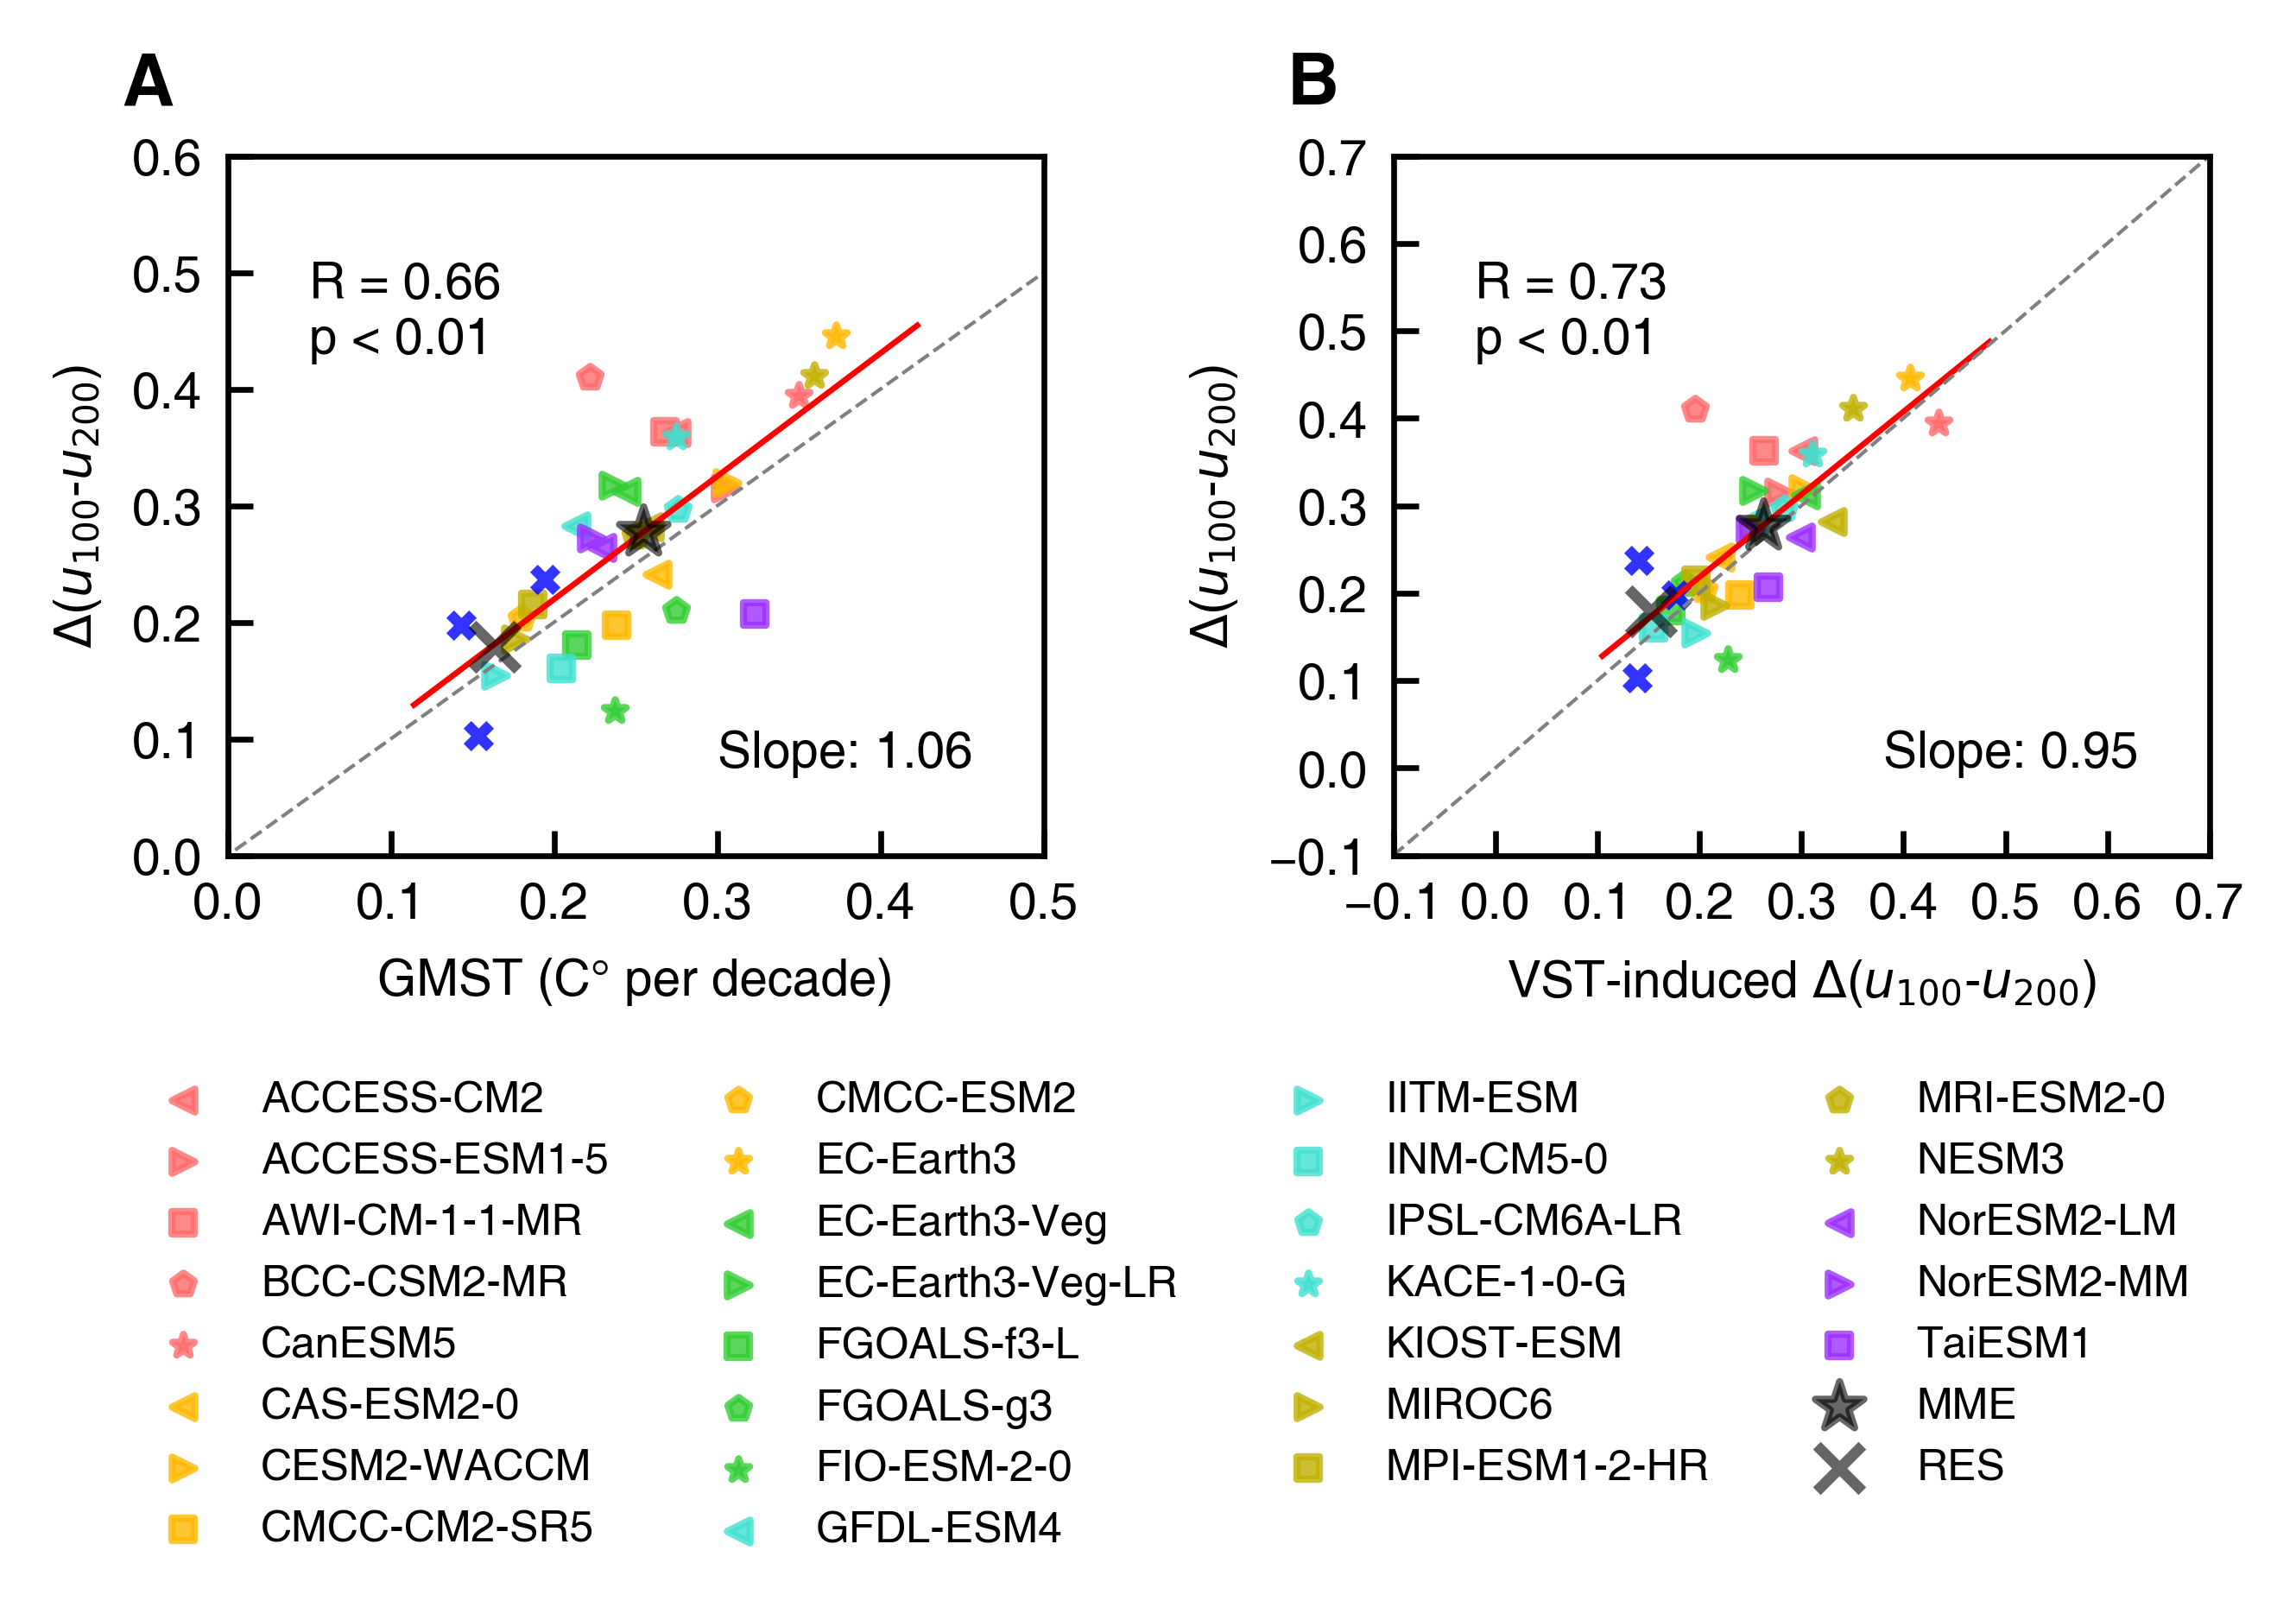

In [6]:

title = ['ANN','DJF','JJA']
fig = plt.figure(figsize=(4.5, 3),dpi=600)
axes = [[.1, .47, .35, .45], [.6, .47, .35, .45]]
models = ['ACCESS-CM2', 'ACCESS-ESM1-5', 'AWI-CM-1-1-MR', 'BCC-CSM2-MR', 'CanESM5', 'CAS-ESM2-0', 'CESM2-WACCM',
          'CMCC-CM2-SR5',
          'CMCC-ESM2', 'EC-Earth3', 'EC-Earth3-Veg', 'EC-Earth3-Veg-LR', 'FGOALS-f3-L', 'FGOALS-g3', 'FIO-ESM-2-0',
          'GFDL-ESM4', 'IITM-ESM', 'INM-CM5-0', 'IPSL-CM6A-LR', 'KACE-1-0-G', 'KIOST-ESM', 'MIROC6', 'MPI-ESM1-2-HR',
          'MRI-ESM2-0', 'NESM3', 'NorESM2-LM', 'NorESM2-MM', 'TaiESM1', 'MME']

# Define marker shapes and colors
#markers = ['o', '^', 's', 'p', '*', 'D', 'H', 'v', 'X', '<', '>', 'P', 'h', '8', 'd']
markers = ['<', '>', 's', 'p', '*']
#colors = ['#FFB6C1', '#FFD700', '#98FB98', '#AFEEEE', '#F0E68C', '#DDA0DD']  # Candy colors
colors = ['#FF6A6A', '#FFB800', '#32CD32', '#40E0D0', '#C1B000', '#9B30FF']
obs_label = ['ERA5','MERRA2','JRA55']
sequence = ['A', 'B', 'C', 'D','E','F']
for j in range(2):
    if j%2 == 1:
        ax = fig.add_axes(axes[j])
        i=j//2
        # 线性回归分析
        slope, intercept, r_value, p_value, std_err = stats.linregress(delta_VST_u_100_200[i],delta_u_100_200[i])
        # 扩展自变量范围
        extended_delta_u = np.linspace(min(delta_VST_u_100_200[i]) - .05, max(delta_VST_u_100_200[i]) + .05, 100)
        # 计算扩展范围内的回归值
        extended_line = slope * extended_delta_u + intercept
        ax.plot(extended_delta_u, extended_line, color='red', linewidth=.8)

        # 绘制散点图
        for m in range(28):
            color_idx = m // 5  # Change color every 5 models
            marker_idx = m % len(markers)  # Cycle through markers
            ax.scatter(delta_VST_u_100_200[i][m], delta_u_100_200[i][m], s=10, marker=markers[marker_idx],
                       color=colors[color_idx], label=models[m],alpha=.8)
        ax.scatter(np.nanmean(delta_VST_u_100_200[i]), np.nanmean(delta_u_100_200[i]), marker='*', s=50, color='k',
                   zorder=20,
                   label=models[-1],alpha=.6)

        print("np.nanmean(delta_VST_u_100_200[i]), np.nanmean(delta_u_100_200[i])")
        print( np.nanmean(delta_VST_u_100_200[i]))
        print(np.nanmean(delta_VST_u_100_200[i])/np.nanmean(delta_u_100_200[i]))

        for m in range(3):
            ax.scatter(VST_obs_trendN[i][m], obs_trendN[i][m], s=10, marker="x",
                       color='b',alpha=.8)#, label=obs_label[m]
        ax.scatter(np.nanmean(VST_obs_trendN[i]), np.nanmean(obs_trendN[i]), marker='x', s=40, color='k',
                   zorder=20,
                   label='RES',alpha=.6)

        print("np.nanmean(VST_obs_trendN[i]), np.nanmean(obs_trendN[i])")
        print( np.nanmean(VST_obs_trendN[i]))
        print(np.nanmean(VST_obs_trendN[i])/np.nanmean(obs_trendN[i]))

        # 添加图例、标签和标题
        if j==1:
            ax.set_ylabel(r'$\Delta$($u_{100}$-$u_{200}$)', fontsize=7)
            ax.set_xlabel(r'VST-induced $\Delta$($u_{100}$-$u_{200}$)', fontsize=7) #(m s$^{-1}$ decade$^{-1}$)
        # 在图上标注斜率和显著性
        ax.annotate(f'Slope: {slope:.2f}',  xy=(0.6, 0.18), xycoords='axes fraction',
                        horizontalalignment='left', verticalalignment='top', fontsize=7)
        ax.annotate(f'R = {r_value:.2f}\np < 0.01', xy=(0.1, 0.85), xycoords='axes fraction',
                    horizontalalignment='left', verticalalignment='top', fontsize=7)
        ax.set_xlim(-.1, .7)
        ax.set_ylim(-.1, .7)
        ax.set_xticks(np.arange(-.1, 0.8, 0.1))  # Set x-axis tick intervals
        ax.set_yticks(np.arange(-.1, 0.8, 0.1))  # Set y-axis tick intervals

        ax.plot([-.1, .7], [-.1, .7], color='grey', linestyle='--', linewidth=.5)
        # 增大坐标轴标签和刻度的字体大小
        ax.tick_params(axis='both', which='major', labelsize=7,direction='in')
        # ax.set_title('Based on T', loc='left', fontsize=14)
        #ax.set_title(title[i], loc='right', fontsize=7)
        ax.text(-0.13, 1.15, sequence[j], transform=ax.transAxes, fontsize=10, fontweight='bold', va='top', ha='left')

    else:
        ax = fig.add_axes(axes[j])
        i = j // 2
        # 线性回归分析
        slope, intercept, r_value, p_value, std_err = stats.linregress(globalmeantemp[i], delta_u_100_200[i])
        # 扩展自变量范围
        extended_gmt = np.linspace(min(globalmeantemp[i]) - .05, max(globalmeantemp[i]) + .05, 100)
        # 计算扩展范围内的回归值
        extended_line = slope * extended_gmt + intercept
        ax.plot(extended_gmt, extended_line, color='red', linewidth=.8)
        # 绘制散点图
        for m in range(len(globalmeantemp[0])):
            color_idx = m // 5  # Change color every 5 models
            marker_idx = m % len(markers)  # Cycle through markers
            ax.scatter(globalmeantemp[i][m], delta_u_100_200[i][m], s=10,
                       marker=markers[marker_idx], color=colors[color_idx], label=models[m],alpha=.8)

        ax.scatter(np.nanmean(globalmeantemp[i]), np.nanmean(delta_u_100_200[i]), marker='*', s=50, color='k',
                   zorder=20,
                   label='mme',alpha=.6)


        for m in range(3):
            ax.scatter(globalmeantemp_obs[i][m], obs_trendN[i][m], s=10,
                       marker='x', color='b',alpha=.8)#, label=models[m]
        ax.scatter(np.nanmean(globalmeantemp_obs[i]), np.nanmean(obs_trendN[i]), marker='x', s=40, color='k',
                   zorder=20,
                   label='RES',alpha=.6)
        # 添加图例、标签和标题
        ax.set_ylabel(r'$\Delta$($u_{100}$-$u_{200}$)', fontsize=7)# (m s$^{-1}$ decade$^{-1}$)
        if i == 0:
            ax.set_xlabel('GMST (C° per decade)', fontsize=7)# (K decade$^{-1}$)
            # 在图上标注斜率和显著性
            ax.annotate(f'Slope: {slope:.2f}', xy=(0.6, 0.18), xycoords='axes fraction',
                        horizontalalignment='left', verticalalignment='top', fontsize=7)
            ax.annotate(f'R = {r_value:.2f}\np < 0.01', xy=(0.1, 0.85), xycoords='axes fraction',
                        horizontalalignment='left', verticalalignment='top', fontsize=7)
        ax.set_xlim(0, .5)
        ax.set_ylim(0, .6)
        ax.set_xticks(np.arange(0, 0.51, 0.1))  # Set x-axis tick intervals
        ax.set_yticks(np.arange(0, 0.61, 0.1))  # Set y-axis tick intervals

        ax.plot([-.1, .6], [-.1, .6], color='grey', linestyle='--', linewidth=.5)
        # 增大坐标轴标签和刻度的字体大小
        ax.tick_params(axis='both', which='major', labelsize=7, direction='in')
        #ax.set_title(title[i], loc='right', fontsize=7)
        ax.text(-0.13, 1.15, sequence[j], transform=ax.transAxes, fontsize=10, fontweight='bold', va='top', ha='left')
        # 增大坐标轴标签和刻度的字体大小
plt.legend(fontsize=6, frameon=False,bbox_to_anchor=(-.28, -1.05),loc='lower center',ncols=4)
plt.savefig('/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/ScienceStyleFigures/Fig.2.u100-u200_VST_ssp585_1980-2020_and_gmt_scatter_ann.png',format='png',dpi=300)
plt.savefig('/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/ScienceStyleFigures/Fig.2.u100-u200_VST_ssp585_1980-2020_and_gmt_scatter_ann.svg',format='svg',dpi=300)
plt.show()